# Gradient descent 

**Implementation of gradient descent from scratch, as part of ridge-regularized multivariate regression** 

I will use the [Boston Housing Prices Data Set](http://www.kellogg.northwestern.edu/faculty/weber/emp/_session_3/boston.htm).  to test the implementation.

**Part 1.** - define objective, evaluation metric and benchmark for the Boston housing prices data set <br>
**Part 2.** - implement gradient descent with and without normalization for linear regression <br>
**Part 3.** - implement ridge regularization

In [32]:
#import some useful libraries...

import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn


%matplotlib inline  
import matplotlib.pyplot as plt  
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf


C:\Users\MBAUser.AMS-MBA-001\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data

In [30]:
from sklearn.datasets import load_boston
bdata = load_boston()

## 1. Experimental setup

We start by defining what we want to achieve, how we are going to measure success and by creating a benchmark to measure how much we are improving

**[...] Objective**: Predict the median home value of a home <br>
**[...] Evaluation metric**: RMSE <br>
**[1.1] Benchmark**: Linear regression using OLS (scikit library) 

### 1.1 - Benchmark

In [19]:
X = pd.DataFrame( data = bdata.data, columns = bdata.feature_names)
y = pd.DataFrame(bdata.target,columns = ['MEDV'])
Xy = pd.concat([X,y], axis = 1)


modelA = smf.ols(formula='MEDV ~ RM', data=Xy).fit()
print(modelA.params)
print("RMSE:", mean_squared_error(y,modelA.predict())**(1/2))

print()

modelB = smf.ols(formula='MEDV ~ RM + np.power(RM,2)', data=Xy).fit() # "**2" doesn't work inside brackets
print(modelB.params)
print("RMSE:", mean_squared_error(y,modelB.predict())**(1/2))

Intercept   -34.670621
RM            9.102109
dtype: float64
RMSE: 6.60307138922

Intercept          66.058847
RM                -22.643262
np.power(RM, 2)     2.470124
dtype: float64
RMSE: 6.17427787376


### Observations

* The RMSE for modelB is lower, which indicated the non-linear model is a better fit of the data (see also plot below)

* A downside of modelB is that the coefficients are more difficult to interpret intuitively. As an example for the second-order model (i.e. incl RM^2), the RM feature is negative. That means that for the first few 'rooms per house' the effect is negative, until RM^2 becomes bigger (at ~ RM = 5 -> RM^2 = 25). It is not intuitive that more rooms make a house cheaper up to 4 rooms and so this might be a case of (overfitting on) outliers at the start.

* Benchmark RMSE: ~6.2, another RMSE to keep in mind is ~5 for the k-NN implementation from scratch (another project)

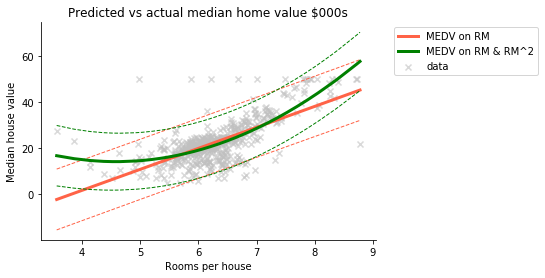

modelA - MEDV on RM Intercept   -34.670621
RM            9.102109
dtype: float64

modelB - MEDV on RM & RM^2 Intercept          66.058847
RM                -22.643262
np.power(RM, 2)     2.470124
dtype: float64


In [5]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Need to sort data on RM first, or run into trouble when plotting
Xy_sorted = Xy.copy(deep=True)
Xy_sorted = Xy_sorted.sort_values(by = 'RM')

modelA_sorted = smf.ols(formula='MEDV ~ RM', data=Xy_sorted).fit()
modelB_sorted = smf.ols(formula='MEDV ~ RM + np.power(RM, 2)', data=Xy_sorted).fit()

# Calculate 95% interval
sdevA, lowerA, upperA = wls_prediction_std(modelA_sorted)
sdevB, lowerB, upperB = wls_prediction_std(modelB_sorted)

# Create graph
fig, ax = plt.subplots()

# Plot plots + intervals
ax.scatter(Xy['RM'], Xy['MEDV'], color = 'silver', marker = 'x', alpha = 0.6,  label = 'data')

ax.plot(Xy['RM'].sort_values(), modelA.predict(Xy['RM'].sort_values()), color = 'tomato', linewidth = 3,  label='MEDV on RM')
ax.plot(Xy['RM'].sort_values(), lowerA, color = 'tomato', linewidth = 1, linestyle ='--')
ax.plot(Xy['RM'].sort_values(), upperA, color = 'tomato', linewidth = 1, linestyle ='--')

ax.plot(Xy['RM'].sort_values(), modelB.predict(Xy['RM'].sort_values()), color = 'g', linewidth = 3, label='MEDV on RM & RM^2')
ax.plot(Xy['RM'].sort_values(), lowerB, color = 'g', linewidth = 1, linestyle ='--')
ax.plot(Xy['RM'].sort_values(), upperB, color = 'g', linewidth = 1, linestyle ='--')



plt.title('Predicted vs actual median home value $000s')
plt.ylabel('Median house value')
plt.xlabel('Rooms per house')

ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

print('modelA - MEDV on RM', modelA.params)
print()
print('modelB - MEDV on RM & RM^2', modelB.params)


## 2. Gradient descent: Linear  Regression

* Function return values of alpha and beta that minimze the loss function
* Reports learning rate, time taken and # of iterations 

* Included a stopping condition in the form of a constant (and hyper parameter) 'epsilon', so that we have a definition for the function having converged.
* Inluded a MaxIterations hyper parameter to prevent divergence

In [34]:
import time

"""
Function
--------
multivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalues, yvalues : narray
    xvalues: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
theta: array
    Array of coefficients alpha and beta[i] with i = 1 ... n for n features

"""
def multivariate_ols(xvalues, yvalues, R=0.01, MaxIterations=1000, epsilon=0.0001):
    start_time = time.time()
    global J_hist
    
    # add column of 1s for theta0 = alpha (i.e. intercept)
    xvalues = np.concatenate((np.ones(shape = (xvalues.shape[0], 1)), xvalues), axis = 1)
    
    # initialize the parameters 
    i = 0
    m = xvalues.shape[0]
    J = 0.0
    J_hist = {}
    theta = np.ones(shape=(xvalues.shape[1],1)) 
    
    # start loop
    while i<MaxIterations:
        # compute loss
        predictions = np.dot(xvalues,theta)
        loss = predictions-yvalues
             
        # gradient descent update step
        #delta = np.dot(xvalues.transpose(), loss) * (1/m)
        theta_change = np.dot(xvalues.transpose(),loss)/m
        theta_new = theta - R * theta_change 
        
        # compute cost
        sqrLoss = np.power(loss,2)
        J_new =  np.sum(sqrLoss) / (2*m)
        J_hist[i+1] = J_new
        
        # check to see if we should continue iterations or not
        # (a)
        if abs(J_new - J) > epsilon:
            J = J_new
        else:
            print('Cost stopped decreasing')
            break
            
        #(b)
        if all(abs(theta-theta_new)>epsilon):
            theta = theta_new
        else:
            print('Theta stopped changing')
            break
        
        i+=1

    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    print("Iterations:",i)
    return theta

### 2.1 Comparing standardized and non-standardized results

In [24]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [21]:
# NON-standardized example with just RM
X_RM_reshape = X['RM'].values.reshape(X['RM'].shape[0], 1) # X input had shape (m,) -- need (m,1)

R_list = [0.0001, 0.001, 0.01, 0.1]

for rates in R_list:
    print("Learning rate:",rates)
    print(bivariate_ols(np.array(X_RM_reshape), np.array(y), R= rates,MaxIterations= 100000,epsilon = 10**(-6)))
    print()

Learning rate: 0.0001
Theta stopped changing
Time taken: 0.09 seconds
Iterations: 869
[[ 1.33424678]
 [ 3.37160282]]

Learning rate: 0.001
Time taken: 5.02 seconds
Iterations: 100000
[[-23.83726154]
 [  7.39904999]]

Learning rate: 0.01
Cost stopped decreasing
Time taken: 1.46 seconds
Iterations: 31450
[[-33.84914675]
 [  8.9729691 ]]

Learning rate: 0.1
Cost stopped decreasing
Time taken: 0.02 seconds
Iterations: 310
[[ -6.40261194e+151]
 [ -4.07277701e+152]]



C:\Users\MBAUser.AMS-MBA-001\Anaconda3\lib\site-packages\ipykernel\__main__.py:60: RuntimeWarning: invalid value encountered in double_scalars


### Observations

**Learning rate has a big impact on converging or not:**
* Too small - the gradient vanishes - the algorithm will stop early because as we approach the minimum, the small learning rate and flattening slope together, result in the cut off point of epsilon being reached for 'change in theta'. We could prevent this by making epsilon much smaller, but that would affect runtime significantly (i.e. more iterations)
* Too big - the gradient explodes

**Even if the cost curve 'flattens' very fast, it is still wortwhile to keep iterations going for a while on the 'flat' part**
* I.e. the curve looks visually flat very fast (see below for an visual example from iteration 20 - 100) but even with small improvements in theta/cost per step, 10.000+ iterations add up..

Cost stopped decreasing
Time taken: 2.24 seconds
Iterations: 50599
[[-34.58846968]
 [  9.08919441]]


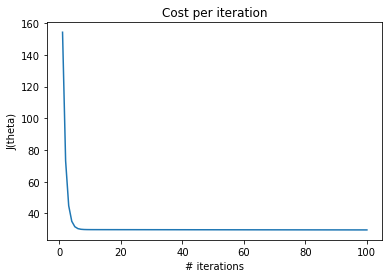

In [7]:
# For fun - plot of learning rate 
print(bivariate_ols(np.array(X_RM_reshape), np.array(y), R= 0.01,MaxIterations= 100000,epsilon = 10**(-8)))

# Create graph
xdata = list(J_hist.keys())
ydata = list(J_hist.values())
a = xdata[0:100]
b = ydata[0:100]
plt.plot(a, b)

plt.title('Cost per iteration')
plt.ylabel('J(theta)')
plt.xlabel('# iterations')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


In [8]:
# Standardized example with CRIM and RM

X_norm = X.copy(deep= True)
X_norm= standardize(X_norm)

X_norm_CRIMRM = X_norm[['CRIM', 'RM']]

# example function call - varying learning rate

R_list = [0.0001, 0.001, 0.01, 0.1]

for rates in R_list:
    print("Learning rate:",rates)
    print(multivariate_ols(np.array(X_norm_CRIMRM), np.array(y), R= rates,MaxIterations= 100000,epsilon = 10**(-6)))
    print()


Learning rate: 0.0001
Theta stopped changing
Time taken: 2.56 seconds
Iterations: 39754
[[ 22.12867732]
 [ -2.25376506]
 [  5.82551692]]

Learning rate: 0.001
Theta stopped changing
Time taken: 0.40 seconds
Iterations: 4529
[[ 22.30096182]
 [ -2.25644947]
 [  5.85423209]]

Learning rate: 0.01
Theta stopped changing
Time taken: 0.03 seconds
Iterations: 460
[[ 22.32131617]
 [ -2.25666572]
 [  5.8576088 ]]

Learning rate: 0.1
Cost stopped decreasing
Time taken: 0.00 seconds
Iterations: 86
[[ 22.53030623]
 [ -2.24931498]
 [  5.89359825]]



In [25]:
# check solution

Xy_norm = Xy.copy(deep = True)
Xy_norm = standardize(Xy_norm)
Xy_norm['MEDV'] = Xy['MEDV']

check_sol = smf.ols(formula='MEDV ~ CRIM + RM', data=Xy_norm).fit()
check_sol.params

Intercept    22.532806
CRIM         -2.248609
RM            5.894417
dtype: float64

### Observations

* MUCH faster and the algorithm now converges very close to the closed-form solution every time (!) Impressive to see how well scaling works.
* Interpretation is a little more difficult (without converting back). It can now be interpreted as e.g.,  'change in 1 stdev in RM | CRIM constant, results in 5.89 increase in stdev in median value (over intercept)' 

In [326]:
# Comparison example of NON-standardized CRIM and RM

# reshape data

X_CRIMRM = X[['CRIM', 'RM']]

# example function call - varying learning rate

R_list = [0.001, 0.01, 0.1]

for rates in R_list:
    print("Learning rate:",rates)
    print(bivariate_ols(np.array(X_CRIMRM), np.array(y), R= rates,MaxIterations= 100000,epsilon = 10**(-6)))
    print()

Learning rate: 0.001
Theta stopped changing
Time taken: 0.03 seconds
Iterations: 295
[[ 1.30212447]
 [-0.36398134]
 [ 3.64075001]]

Learning rate: 0.01
Theta stopped changing
Time taken: 1.02 seconds
Iterations: 21792
[[-26.62945702]
 [ -0.27074879]
 [  7.98219973]]

Learning rate: 0.1
Cost stopped decreasing
Time taken: 0.01 seconds
Iterations: 165
[[ -6.18242669e+151]
 [ -9.61773548e+152]
 [ -3.77104665e+152]]



C:\Users\MBAUser.AMS-MBA-001\Anaconda3\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: overflow encountered in power
C:\Users\MBAUser.AMS-MBA-001\Anaconda3\lib\site-packages\ipykernel\__main__.py:62: RuntimeWarning: invalid value encountered in double_scalars


### Observations
* Running time for standardized variables is dramatically reduced (about 20-30x faster) since it reduces # iterations needed for convergence (because of the better shaped convex function)
* With standardized variables all iterations converge,.. non-standardized do not (in this case, only for R = 0.01)

## 2.2 Prediction

I will use the fitted model to make predictions about housing prices and compare versus our benchmark. For the RMSE, I'm using 25-fold cross-validation. I'll keep the best test intercept and slope coefficients.

In [35]:
# Create Kfold with 25 folds
kf = KFold(n=len(Xy_norm), n_folds=25)

# Initialize some useful variables
intercept, slopes = [], []
rmse_list = []
rmse_best = 10**6

# Iterate through folds   
for train, test in kf:
    # Create training input and run gradient descent
    xvalue_matrix = np.array(Xy_norm.iloc[train][['CRIM', 'RM']])
    yvalues = np.array(Xy_norm.iloc[train].MEDV).reshape(Xy_norm.iloc[train].shape[0], 1) 
    theta = multivariate_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=100000, epsilon = 10**(-8))
    
    # Create test input
    xvalue_matrix_test = np.array(Xy_norm.iloc[test][['CRIM', 'RM']])
    xvalue_matrix_test = np.concatenate((np.ones(shape = (xvalue_matrix_test.shape[0], 1)), xvalue_matrix_test), axis = 1)
    yvalues_test = np.array(Xy_norm.iloc[test].MEDV).reshape(Xy_norm.iloc[test].shape[0], 1)
    
    # Compute test predictions and rmse (using thetas from training)
    predictions = np.dot(xvalue_matrix_test,theta)
    loss = predictions - yvalues_test
    sqrloss = np.power(loss, 2)   
    rmse_test = np.sqrt(np.sum(sqrloss) / (len(sqrloss)))
    
    # Only store intercept and slopes for best fold (=lowest rmse)
    rmse_list.append(rmse_test)
    if rmse_test < rmse_best:
        rmse_best = rmse_test
        intercept, slopes = theta[0], theta[1:3]

print()
print('RESULTS')
print()
print('Best rmse:', rmse_best)
print('intercept: ', theta[0])
print('slopes for CRIM and RM: ', theta[1:3])

Theta stopped changing
Time taken: 0.06 seconds
Iterations: 916
Theta stopped changing
Time taken: 0.04 seconds
Iterations: 745
Theta stopped changing
Time taken: 0.04 seconds
Iterations: 738
Cost stopped decreasing
Time taken: 0.05 seconds
Iterations: 995
Cost stopped decreasing
Time taken: 0.05 seconds
Iterations: 1009
Cost stopped decreasing
Time taken: 0.05 seconds
Iterations: 998
Cost stopped decreasing
Time taken: 0.05 seconds
Iterations: 999
Cost stopped decreasing
Time taken: 0.05 seconds
Iterations: 994
Cost stopped decreasing
Time taken: 0.05 seconds
Iterations: 999
Cost stopped decreasing
Time taken: 0.05 seconds
Iterations: 1052
Cost stopped decreasing
Time taken: 0.05 seconds
Iterations: 999
Cost stopped decreasing
Time taken: 0.05 seconds
Iterations: 1033
Cost stopped decreasing
Time taken: 0.05 seconds
Iterations: 1053
Cost stopped decreasing
Time taken: 0.05 seconds
Iterations: 1044
Cost stopped decreasing
Time taken: 0.06 seconds
Iterations: 1002
Cost stopped decreasin

In [37]:
print("best test RMSE (avg):", np.average(rmse_list))
print()
print("OLS params:", check_sol.params)

best test RMSE (avg): 5.52526843024

OLS params: Intercept    22.532806
CRIM         -2.248609
RM            5.894417
dtype: float64


### Observations
* The intercept and slopes for the best fold, are very close to the intercept and slopes for the full dataset (and thus also closed-form solution)
* My average test RMSE from above is 5.52. The benchmark RMSE is ~6.2

## 3. Regularization 

### 3.1 Feature preparation

* To put regularization to the test and to be more comprehensive in feature selection I will create new interaction variables between each possible pair of the original features. Ie if we originally had *K* features, we should now have K+(K*(K+1))/2 features.

* For simplicity for the moment I created a single training and testing set by randomly sampling 66% of the data and set aside the remaining 34% as the test set.

In [405]:
# Create features

X_xn = X.copy(deep=True)
features = X_xn.columns.tolist()
features2 = features.copy()

for i in features:
    features2.remove(i)
    for j in features2:
        X_xn[i+":"+j] = np.array(X_xn[i]) * np.array(X_xn[j])

print('Number of features should be: ', len(features) + (len(features)*(len(features)-1)/2))
print("Number of features in X_in: ", X_xn.shape[1])


# Normalize
X_xn_norm = standardize(X_xn)

# Add back target variable

Xy_xn_norm = X_xn_norm.copy(deep=True)
Xy_xn_norm['MEDV'] = Xy['MEDV']

print('Number of features + target: ', Xy_xn_norm.shape[1])


Number of features should be:  91.0
Number of features in X_in:  91
Number of features + target:  92


In [411]:
# Create train-test split
def train_test_split(df, split_percentage=0.66):
    train_index = np.random.choice(df.index, size = int(split_percentage*len(df.index)), replace = False)
    test_index = df.index[~df.index.isin(train_index)]
    
    df_train = df.iloc[train_index]
    df_test = df.iloc[test_index]
    
    return df_train, df_test

df_train, df_test = train_test_split(Xy_xn_norm)

### 3.2 Overfitting (sort of) for a benchmark
Now, I'll overfit the training data using all of those K+(K*(K+1))/2 features and use the multivariate_ols function to compute an RMSE. We'll try and improve on this with regularization.

In [442]:
from sklearn.metrics import mean_squared_error


# Prepare training input to run gradient descent
xvalue_matrix = df_train.copy(deep=True)
del xvalue_matrix['MEDV']
xvalue_matrix = np.array(xvalue_matrix)
yvalues = np.array(df_train.MEDV).reshape(df_train.shape[0], 1) 
theta = multivariate_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=100000, epsilon = 10**(-13))

# Prepare train input for RMSE
xvalue_matrix_train = np.concatenate((np.ones(shape = (xvalue_matrix.shape[0], 1)), xvalue_matrix), axis = 1)
predictions_train = np.dot(xvalue_matrix_train,theta)

# Prepare test input for RMSE
xvalue_matrix_test = df_test.copy(deep=True)
del xvalue_matrix_test['MEDV']
xvalue_matrix_test = np.array(xvalue_matrix_test)
xvalue_matrix_test = np.concatenate((np.ones(shape = (xvalue_matrix_test.shape[0], 1)), xvalue_matrix_test), axis = 1)
yvalues_test = np.array(df_test.MEDV).reshape(df_test.shape[0], 1)
predictions_test = np.dot(xvalue_matrix_test,theta)

rmse_train = mean_squared_error(yvalues, predictions_train )**(1/2)
rmse_test = mean_squared_error(yvalues_test, predictions_test )**(1/2)

print('Train rmse: ', rmse_train)
print('Test rmse: ', rmse_test)


Time taken: 9.63 seconds
Iterations: 100000
Train rmse:  2.53489409366
Test rmse:  4.13985547925


### Observations
* The RMSE of the training set is significantly lower than the RMSE for the test set. This indicates overfitting.
* The RSMSE for the test set though, is still lower than the test RMSE from 3.2 and k-NN. That would indicate that adding the interactions variables helps for a better fit of the model (ie data is non-linear)
* It is important to keep your hyper parameters in mind. Initially the train & test RMSE seemed to converge to ~ the same number, regardless of learning rate. After some thinking, I realized that this is likely because with so many (correlated) variables the gradient is likely to become very small fast for at least one of those variables. Since I check my epsilon across all variables and stop the algorithm if any one reaches the epsilon treshold, it was important to make epsilon smaller.

### 3.3 Ridge regularization
Next, I incorporate L2 (Ridge) regularization into the multivariate_ols regression. Below I wrote a new version of the gradient descent algorithm that includes a regularization term "lambda" to penalize excessive complexity. 

I will then re-fit the model from above on the training data for several different values of lambda and report the RMSE. Note: This regularization is the reverse idea of forward-selection that I used for k-NN.

Mini-celebration: this means I implemented ridge-regularized multivariate regression using gradient descent optimization, from scratch (!)

In [480]:
"""
Function
--------
multivariate_ols_L2
    Gradient Descent to minimize OLS, with L2 regularization. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    
epsilon: Int
    stopping condition when either cost function or theta stop changing by indicated amount
    
Lam: float
    regularization penalty
    

Returns
-------
theta: array
    Array of coefficients alpha and beta[i] with i = 1 ... n for n features
    
"""

## SAME CODE AS ABOVE

def multivariate_ols_L2(xvalue_matrix, yvalues, R=0.01, MaxIterations=100000, epsilon = 10**(-13), Lam = 0.1):
    start_time = time.time()
    global J_hist
    
    # add column of 1s for theta0 = alpha (i.e. intercept)
    xvalue_matrix = np.concatenate((np.ones(shape = (xvalue_matrix.shape[0], 1)), xvalue_matrix), axis = 1)
    
    # initialize the parameters 
    i = 0
    m = xvalue_matrix.shape[0]
    J = 0.0
    J_hist = {}
    theta = np.ones(shape=(xvalue_matrix.shape[1],1)) 
    
    # start loop
    while i<MaxIterations:
        # compute loss
        predictions = np.dot(xvalue_matrix,theta)
        loss = predictions-yvalues
             
        # gradient descent update step INCL. REGULARIZATION
        theta_reg = theta.copy()
        theta_reg[0] = 0                   # separate theta_reg (which includes a column of 0's for theta[0]=alpha)
        
        theta_change = np.dot(xvalue_matrix.transpose(),loss)/m + (Lam/m)*theta_reg
        theta_new = theta - R * theta_change 
        
        # compute cost INCL. REGULARIZATION
        sqrLoss = np.power(loss,2)
        J_new =  (np.sum(sqrLoss) / (2*m)) + Lam*np.sum(np.power(theta_reg,2))
        J_hist[i+1] = J_new
        
        # check to see if we should continue iterations or not
        # (a)
        if abs(J_new - J) > epsilon:
            J = J_new
        else:
            print('Cost stopped decreasing')
            break
            
        #(b)
        if all(abs(theta-theta_new)>epsilon):
            theta = theta_new
        else:
            print('Theta stopped changing')
            break
        
        i+=1

    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    print("Iterations:",i)
    return theta

In [497]:
# Prepare Xy training input to run gradient descent
xvalue_matrix = df_train.copy(deep=True)
del xvalue_matrix['MEDV']
yvalues = df_train.MEDV.values.reshape(df_train.shape[0], 1) 

# Run gradient descent for different values of Lam
Lam_list = [0.1, 0.3, 1, 3, 6, 8,  10, 100, 1000]

for i in Lam_list:
    theta = multivariate_ols_L2(np.array(xvalue_matrix), np.array(yvalues), \
                            R= 0.01, MaxIterations= 500000, epsilon = 10**(-13), Lam = i)

    # Prepare train input for RMSE
    X_train = np.concatenate((np.ones(shape = (xvalue_matrix.shape[0], 1)), xvalue_matrix), axis = 1)
    yhat_train = np.dot(X_train,theta)

    # Prepare test input for RMSE
    X_test = df_test.copy(deep=True)
    del X_test['MEDV']
    X_test = np.array(X_test)
    X_test = np.concatenate((np.ones(shape = (X_test.shape[0], 1)), X_test), axis = 1)

    yvalues_test = np.array(df_test.MEDV).reshape(df_test.shape[0], 1)
    yhat_test = np.dot(X_test,theta)

    rmse_train = mean_squared_error(yvalues, yhat_train )**(1/2)
    rmse_test = mean_squared_error(yvalues_test, yhat_test )**(1/2)

    print('lambda: ', i)
    print('Train rmse: ', rmse_train)
    print('Test rmse: ', rmse_test)
    print()

Theta stopped changing
Time taken: 8.09 seconds
Iterations: 74324
lambda:  0.1
Train rmse:  2.59077577467
Test rmse:  3.90728628459

Theta stopped changing
Time taken: 13.99 seconds
Iterations: 112948
lambda:  0.3
Train rmse:  2.61417424043
Test rmse:  3.79763502431

Theta stopped changing
Time taken: 14.03 seconds
Iterations: 135596
lambda:  1
Train rmse:  2.82511712367
Test rmse:  3.4625273

Theta stopped changing
Time taken: 3.50 seconds
Iterations: 32267
lambda:  3
Train rmse:  3.1773780409
Test rmse:  3.35211130195

Theta stopped changing
Time taken: 5.33 seconds
Iterations: 41297
lambda:  6
Train rmse:  3.43924481184
Test rmse:  3.4228646659

Theta stopped changing
Time taken: 3.50 seconds
Iterations: 31640
lambda:  8
Train rmse:  3.55728383001
Test rmse:  3.47335464669

Theta stopped changing
Time taken: 3.35 seconds
Iterations: 31491
lambda:  10
Train rmse:  3.65041769332
Test rmse:  3.51791558552

Theta stopped changing
Time taken: 0.47 seconds
Iterations: 3821
lambda:  100
Tr

### Observations
* As lambda is set higher from 0.1 to 6 (i.e. higher cost for the algorithm to include more parameters) - you see train rmse increasing and test rmse decreasing. This seems to indicate that we are succesful in reducing overfitting to the training data.
* If we set lambda too high (e.g., >8 in this case) test rmse starts increases together with train rmse, which could indicate we are now underfitting for both (by penalizing all variables too heavily)
* The best rmse for the regularized algorithm above performs better in terms of rmse (3.42), compared to the rmse from Q2.3 (5.52) and the rmse from nearest neighbor (5.44)

### 3.4 Cross-validate lambda

To be a bit more rigorous, I can use k-fold cross-validation to select the optimal value of lambda. I also created a scatter plot that shows RMSE as a function of lambda and a cool plot that shows how regularization affects the different coefficient values.

In [507]:
Xy_xn_norm.shape

(506, 92)

In [554]:
# Cross-Fold validation, 10 folds
kf = KFold(len(Xy_xn_norm), n_folds=10)

# Initialize some useful variables
lambda_list = []
avg_rmse_train_list = []
avg_rmse_test_list = []


for lam in np.arange(0,10,.5):
    # Iterate through folds   
    for train, test in kf:
        rmse_train_list = []
        rmse_test_list = []
        
        # Create training input and run gradient descent
        Xvalues = Xy_xn_norm.copy(deep=True)
        del Xvalues['MEDV']
        xvalue_matrix = Xvalues.iloc[train]
        
        yvalues = Xy_xn_norm.iloc[train].MEDV.values.reshape(Xy_xn_norm.iloc[train].shape[0], 1)

        theta = multivariate_ols_L2(np.array(xvalue_matrix), np.array(yvalues), R=0.01, MaxIterations=200000, \
                                 epsilon = 10**(-13), Lam = lam)
    
        # Prepare train input for RMSE
        X_train = np.concatenate((np.ones(shape = (xvalue_matrix.shape[0], 1)), xvalue_matrix), axis = 1)
        yhat_train = np.dot(X_train,theta)
        #yvalues = yvalues

        # Prepare test input for RMSE
        X_test = Xvalues.iloc[test]
        X_test = np.array(X_test)
        X_test = np.concatenate((np.ones(shape = (X_test.shape[0], 1)), X_test), axis = 1)

        yhat_test = np.dot(X_test,theta)
        
        yvalues_test = np.array(Xy_xn_norm.iloc[test].MEDV.values.reshape(Xy_xn_norm.iloc[test].shape[0], 1))

        rmse_train = mean_squared_error(yvalues, yhat_train )**(1/2)
        rmse_test = mean_squared_error(yvalues_test, yhat_test )**(1/2)
        
        rmse_train_list.append(rmse_train)
        rmse_test_list.append(rmse_test)
        
    avg_rmse_train_list.append(np.average(rmse_train_list))
    avg_rmse_test_list.append(np.average(rmse_test_list))
    lambda_list.append(lam)


Time taken: 23.63 seconds
Iterations: 200000
Time taken: 23.54 seconds
Iterations: 200000
Time taken: 28.97 seconds
Iterations: 200000
Time taken: 25.58 seconds
Iterations: 200000
Time taken: 26.79 seconds
Iterations: 200000
Theta stopped changing
Time taken: 27.96 seconds
Iterations: 199231
Theta stopped changing
Time taken: 13.66 seconds
Iterations: 90758
Time taken: 25.91 seconds
Iterations: 200000
Time taken: 23.94 seconds
Iterations: 200000
Theta stopped changing
Time taken: 23.30 seconds
Iterations: 165087
Time taken: 26.64 seconds
Iterations: 200000
Time taken: 25.28 seconds
Iterations: 200000
Time taken: 29.54 seconds
Iterations: 200000
Time taken: 29.62 seconds
Iterations: 200000
Theta stopped changing
Time taken: 17.94 seconds
Iterations: 138027
Time taken: 25.67 seconds
Iterations: 200000
Theta stopped changing
Time taken: 20.54 seconds
Iterations: 165914
Theta stopped changing
Time taken: 27.57 seconds
Iterations: 197099
Theta stopped changing
Time taken: 33.58 seconds
Iter

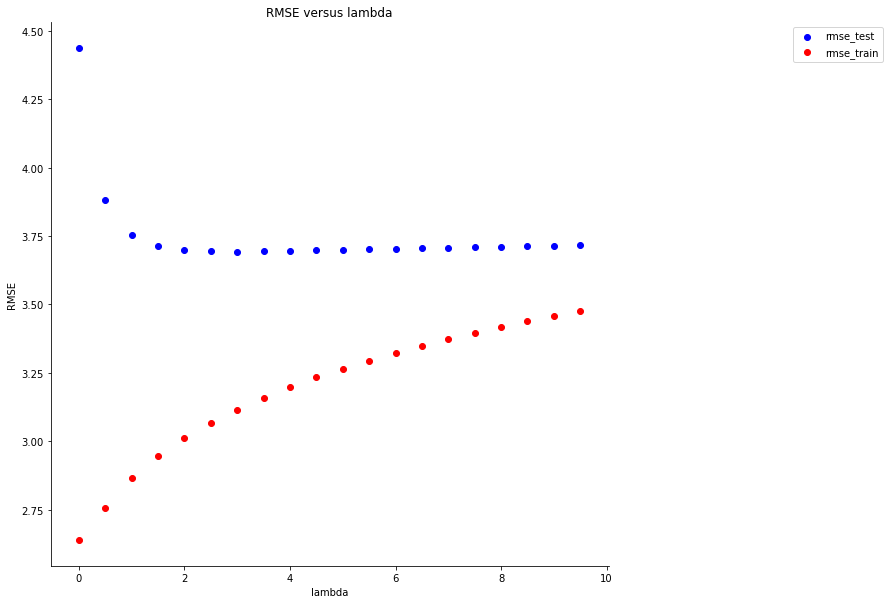

In [556]:
# Create graph

fig, ax = plt.subplots(figsize = (10,10))

x = np.array(lambda_list)
y_test = np.array(avg_rmse_test_list)
y_train = np.array(avg_rmse_train_list)

ax.scatter(x, y_test, color = 'b', marker = 'o',  label = 'rmse_test')
ax.scatter(x, y_train, color = 'r', marker = 'o',  label = 'rmse_train')

plt.title('RMSE versus lambda')
plt.ylabel('RMSE')
plt.xlabel('lambda')

ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

### Observations
* As posited before, cross validation confirms that increasing lambda initially helps to reduce overfitting on the training data. 
* For higher values of lambda, we would expect the error for both test and training data to start rising again, because of underfitting. You already see the test/train RMSEs converging and they will likely trend up together afterwards.  (I'll leave that to a faster computer to validate though)

In [686]:
# Cross-Fold validation, 10 folds
kf = KFold(len(Xy_xn_norm), n_folds=10)

# Initialize some useful variables
lam_list2 = []
avg_theta_list = []


# regress for 10 values of lambda, save coefficient values
for lam in np.arange(0,10,0.5):  
    # loop through folds
    theta_list = []
    for train, test in kf:   
        # Create training input 
        Xvalues = Xy_xn_norm.copy(deep=True)
        del Xvalues['MEDV']
        xvalue_matrix = Xvalues.iloc[train]
        
        yvalues = Xy_xn_norm.iloc[train].MEDV.values.reshape(Xy_xn_norm.iloc[train].shape[0], 1)
        
        # Run gradient descent
        theta = multivariate_ols_L2(np.array(xvalue_matrix), np.array(yvalues), R=0.01, MaxIterations=100000, \
                                 epsilon = 10**(-13), Lam = lam)
        
        # Store values
        theta_list.append(theta[1:14]) # Only store 13 original features (excl. alpha intercept)
    avg_theta_list.append([sum(x)/float(len(x)) for x in zip(*theta_list)])
    lam_list2.append(lam)

Time taken: 12.63 seconds
Iterations: 100000
Time taken: 11.07 seconds
Iterations: 100000
Time taken: 11.02 seconds
Iterations: 100000
Time taken: 12.81 seconds
Iterations: 100000
Time taken: 14.00 seconds
Iterations: 100000
Time taken: 12.73 seconds
Iterations: 100000
Theta stopped changing
Time taken: 12.32 seconds
Iterations: 90758
Time taken: 12.23 seconds
Iterations: 100000
Time taken: 13.58 seconds
Iterations: 100000
Time taken: 13.71 seconds
Iterations: 100000
Time taken: 12.09 seconds
Iterations: 100000
Time taken: 12.02 seconds
Iterations: 100000
Time taken: 11.53 seconds
Iterations: 100000
Time taken: 12.13 seconds
Iterations: 100000
Time taken: 11.91 seconds
Iterations: 100000
Time taken: 13.51 seconds
Iterations: 100000
Time taken: 15.10 seconds
Iterations: 100000
Time taken: 14.14 seconds
Iterations: 100000
Time taken: 12.99 seconds
Iterations: 100000
Time taken: 14.49 seconds
Iterations: 100000
Time taken: 14.38 seconds
Iterations: 100000
Time taken: 12.13 seconds
Iterati

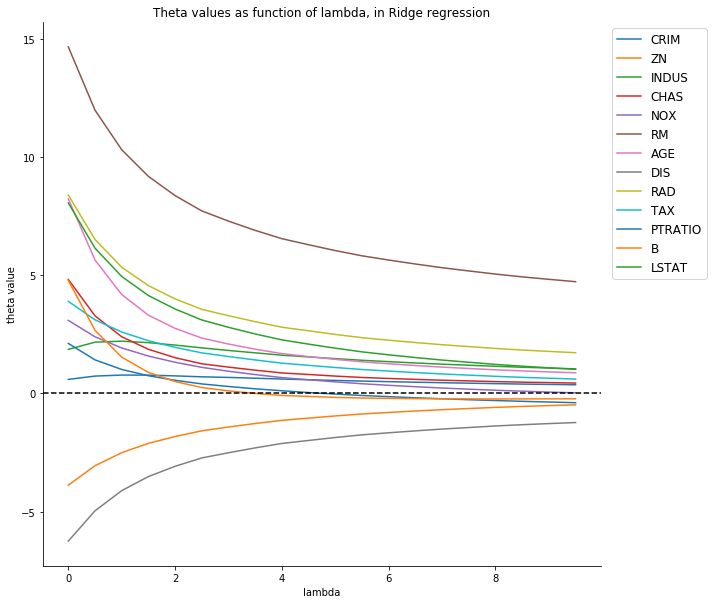

In [707]:
names = xvalue_matrix.columns[0:13]
df = pd.DataFrame(avg_theta_list, index = lam_list2, columns = names)

fig, ax = plt.subplots(figsize = (10,10))
xtest = list(df.index)

for i in names:
    ytest = df[i].values
    ax.plot(xtest, ytest, label = i)
 
plt.axhline(y=0.0, color='black', linestyle='--')

plt.title('Theta values as function of lambda, in Ridge regression')
plt.ylabel('theta value')
plt.xlabel('lambda')

ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize = 12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



###  Observations
* As lambda increases, the coefficients of the regularized variables will tend towards 0. (high cost of theta values)
* (in this case) the effect of regularization is very strong at the start
* Its interesting to see what might be (de)correlation effects, when for some features the sign of theta even switches(!) for different values of lambda